In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

rng = np.random.default_rng(1)

In [14]:
def pairs_in(pairs, S_pairs):
    query_pairs = pairs.copy()
    query_pairs = np.expand_dims(query_pairs, axis=1)  # shape becomes (k, 1, 2) for efficient broadcasting, where k=pairs.shape[0]
    matches = np.all(query_pairs == S_pairs, axis=-1)  # shape is (k, n), where n=S_pairs.shape[0]
    hits = np.any(matches, axis=-1)  # shape is (k)
    return hits

def draw_unique_pairs(S, k, max_tries=1e3):
    assert S.shape[0] % 2 == 0
    out = np.zeros((k, 2), dtype=S.dtype)
    pairs_drawn = 0
    tries = 0
    while pairs_drawn != k:
        # Generate candidate pairs by permuting S, then generate pairs by adjacent elements
        S_perm = rng.permutation(S)
        S_perm_pairs = S_perm.reshape(S_perm.shape[0] // 2, 2)
        tries += 1
        # Base case: accept all candidate pairs (up to k)
        if pairs_drawn == 0:
            pairs_drawn = min(k, S_perm_pairs.shape[0])
            out[0:pairs_drawn] = S_perm_pairs[0:pairs_drawn]
        # Otherwise: accept only those candidate pairs that haven't yet been added to `out`.
        else:
            S_perm = rng.permutation(S)
            S_perm_pairs = S_perm.reshape(S_perm.shape[0] // 2, 2)
            S_perm_pairs_full = np.concatenate([S_perm_pairs, np.flip(S_perm_pairs, axis=-1)])
            hits = pairs_in(S_perm_pairs_full, out[0:pairs_drawn])
            hits = hits[:hits.shape[0] // 2] | hits[hits.shape[0] // 2:]  # reduce hits to account for "reversed" pairs
            keeps = S_perm_pairs[~hits]
            if keeps.shape[0] > 0:
                pairs_to_add = min(k - pairs_drawn, keeps.shape[0])
                out[pairs_drawn:pairs_drawn+pairs_to_add] = keeps[:pairs_to_add]
                pairs_drawn += pairs_to_add
        if tries >= max_tries:
            print(f'[WARN] N={S.shape[0]} k={k} \tOnly found {pairs_drawn} pairs after {tries} attempts.')
            break
    return out, tries >= max_tries

def experiment(S, k):
    unique_pairs, timeout = draw_unique_pairs(S, k)
    unique_pairs_full = np.concatenate([unique_pairs, np.flip(unique_pairs, axis=-1)])
    hits = pairs_in(unique_pairs_full, S.reshape(S.shape[0] // 2, 2))
    return np.sum(hits), timeout

In [16]:
%%time

Ns = np.arange(2, 51, step=2)
max_k = 2000
iters_per_param = 20

results = []

for N in Ns:
    S = np.arange(1, N+1)
    timeout = False
    for k in range(1, max_k):
        for _ in range(iters_per_param):
            n_hits, timeout = experiment(S, k)
            if timeout:
                break
            results.append({'N': N, 'k': k, 'duplicates': n_hits})
        if timeout:
            break

[WARN] N=2 k=2 	Only found 1 pairs after 1000 attempts.
[WARN] N=4 k=7 	Only found 6 pairs after 1000 attempts.
[WARN] N=6 k=16 	Only found 15 pairs after 1000 attempts.
[WARN] N=8 k=29 	Only found 28 pairs after 1000 attempts.
[WARN] N=10 k=46 	Only found 45 pairs after 1000 attempts.
[WARN] N=12 k=67 	Only found 66 pairs after 1000 attempts.
[WARN] N=14 k=92 	Only found 91 pairs after 1000 attempts.
[WARN] N=16 k=121 	Only found 120 pairs after 1000 attempts.
[WARN] N=18 k=154 	Only found 153 pairs after 1000 attempts.
[WARN] N=20 k=191 	Only found 190 pairs after 1000 attempts.
[WARN] N=22 k=232 	Only found 231 pairs after 1000 attempts.
[WARN] N=24 k=277 	Only found 276 pairs after 1000 attempts.
[WARN] N=26 k=326 	Only found 325 pairs after 1000 attempts.
[WARN] N=28 k=379 	Only found 378 pairs after 1000 attempts.
[WARN] N=30 k=436 	Only found 435 pairs after 1000 attempts.
[WARN] N=32 k=497 	Only found 496 pairs after 1000 attempts.
[WARN] N=34 k=562 	Only found 561 pairs after 

In [86]:
results_df = pd.DataFrame(results)
results_df.to_csv('sim.csv', index=False)

In [2]:
results_df = pd.read_csv('sim.csv')

# Reparameterize from "k" to "rounds of a full lunch tag"
results_df = results_df.query('k % N == 0')
results_df['round'] = results_df['k'] // results_df['N']

# Focus on whether any duplicates at all were encountered
results_df['has_duplicate'] = results_df['duplicates'] != 0

# Aggregate mean and s.e.m.
results_summary = results_df.groupby(['N', 'k', 'round'])['has_duplicate'].agg(['mean', 'sem'])
results_summary

mean       sem
N  k    round                
4  4    1      0.80  0.091766
6  6    1      0.80  0.091766
   12   2      1.00  0.000000
8  8    1      0.75  0.099340
   16   2      1.00  0.000000
...             ...       ...
50 1000 20     1.00  0.000000
   1050 21     1.00  0.000000
   1100 22     1.00  0.000000
   1150 23     1.00  0.000000
   1200 24     1.00  0.000000

[300 rows x 2 columns]

In [17]:
N = results_summary.index.get_level_values('N')
k = results_summary.index.get_level_values('k')
rounds = results_summary.index.get_level_values('round')
mean = results_summary['mean'].values

Text(0.5, 0, 'P(duplicate)')

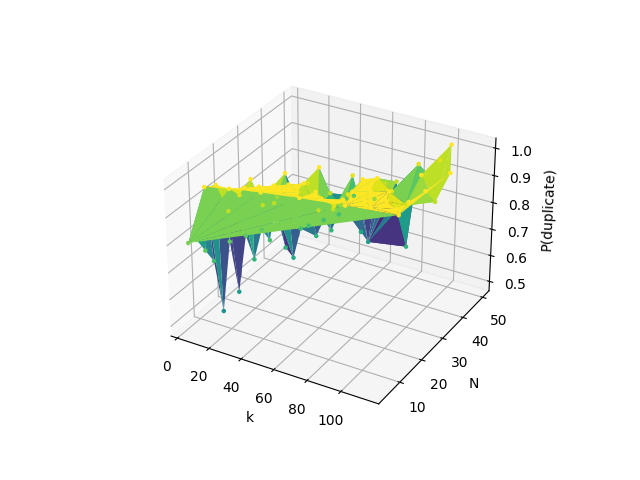

In [138]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(k[k < 120], N[k < 120], mean[k < 120], cmap='viridis', edgecolor='none')
ax.scatter3D(k[k < 120], N[k < 120], mean[k < 120], c=mean[k < 120], cmap='viridis', vmin=0, vmax=1, s=5, alpha=1)
ax.set_ylabel('N')
ax.set_xlabel('k')
# ax.set_ylabel('round')
ax.set_zlabel('P(duplicate)')

In [115]:
max_k = results_df.reset_index(drop=True).groupby('N')['k'].agg('max')
X = max_k.index.values
Y = max_k.values

f_p2 = lambda x, a, b, c: a + b * x + c * x**2
popt, pcov = scipy.optimize.curve_fit(f_p2, xdata=X, ydata=Y)
print(popt)

[-2.21933583e-12 -1.00000000e+00  5.00000000e-01]


/home/cove/Documents/lunchtag/venv-lunchtag/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Squared error 0.0


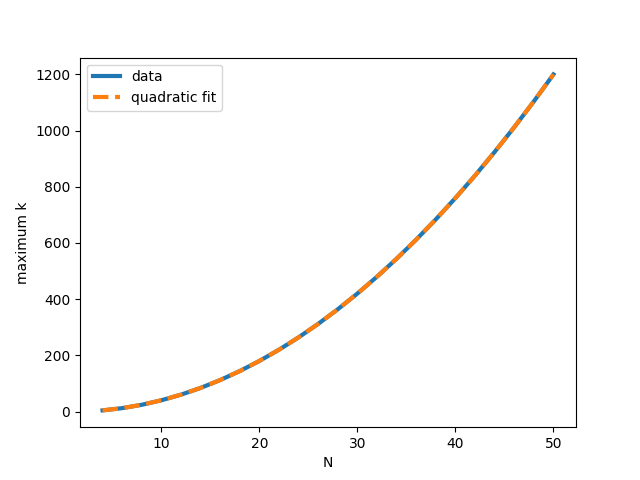

In [122]:
# (-X + 0.5X^2) = X(X/2 - 1)
print('Squared error', np.sum((Y - (X * (X/2 - 1)))**2))

plt.figure()
max_k.plot(ylabel='maximum k', label='data', linewidth=3)
plt.plot(X, X * (X/2 - 1), label='quadratic fit', linestyle='dashed', linewidth=3)
plt.legend()

In [13]:
results_df = pd.read_csv('sim.csv')
results_df['has_duplicate'] = results_df['duplicates'] != 0
results_df = results_df.query('k == 1')
summ = results_df.groupby(['N', 'k'])['has_duplicate'].agg(['mean', 'sem']).reset_index()

In [24]:
%matplotlib widget

X = summ['N']
Y = summ['mean']
err = summ['sem']
plt.plot(X, Y, label='data$\\pm$SEM')
plt.fill_between(X, Y-err, Y+err, alpha=0.5)
plt.plot(X, 1/(X-1), label='1/(N-1)')
plt.legend()
plt.xlabel('N')
plt.ylabel('P(duplicate)')
plt.title('k=1')

plt.show()